# Sixth
batch size 2048 lr 1e-3 swish mult2, filtered HL features

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Options

In [2]:
classTrainFeatures = filtered_features_0
classModel = 'modelSwish'
varSet = "filtered_features_0"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 2048, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs}

print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 29 features: ['ntracks', 'ntowers', 'jetMass', 'jetPt', 'max_track_pT', 'max_track_eta', 'min_track_eta', 'sum_tower_Ehad', 'max_tower_E', 'sum_track_pT', 'mean_tower_Eem', 'mean_track_pT', 'tower_Eem_frac', 'min_track_pT', 'sum_tower_Eem', 'min_tower_E', 'jetPhi', 'sum_tower_E', 'min_tower_eta', 'tower_Ehad_frac', 'max_tower_Eem', 'mean_tower_E', 'max_tower_Ehad', 'max_tower_eta', 'mean_tower_eta', 'jetEta', 'mean_tower_Ehad', 'mean_track_eta', 'min_tower_Eem']


## Import data

In [3]:
trainData = h5py.File(dirLoc + 'train.hdf5', "r+")
valData = h5py.File(dirLoc + 'testing.hdf5', "r+")

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.783s 


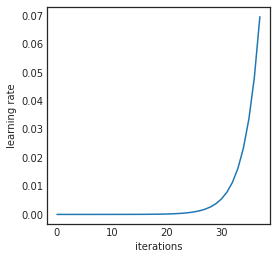

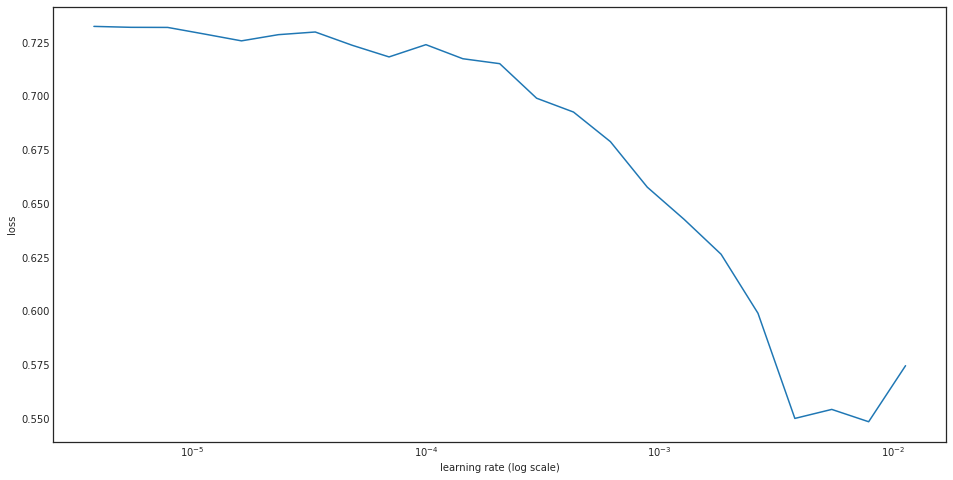

______________________________________



In [4]:
lrFinder = batchLRFindClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, lrBounds=[1e-7,1e-1], trainOnWeights=False, verbose=0)

In [4]:
compileArgs['lr'] = 5e-2

## Train classifier

In [ ]:
results, histories = batchTrainClassifier(trainData, nSplits, getClassifier, modelParams, trainParams, patience=100, cosAnnealMult=2, trainOnWeights=False, maxEpochs=maxEpochs, verbose=1)

Using cosine annealing
Running fold 1 / 10
2 classes found, running in binary mode

1 New best found: 0.520253330708
2 New best found: 0.493863745643
3 New best found: 0.488134781063
5 New best found: 0.486390749186
6 New best found: 0.483955857465
7 New best found: 0.483432569074
12 New best found: 0.482608730298
13 New best found: 0.482521382287
14 New best found: 0.482078903009
25 New best found: 0.481721675461
27 New best found: 0.481538919634
28 New best found: 0.481535892515
29 New best found: 0.481437568234
30 New best found: 0.481309970729
58 New best found: 0.481050593956
59 New best found: 0.4810096433
60 New best found: 0.480879916457
Early stopping after 160 epochs
Score is: {'loss': 0.4808799164567587, 'AUC': 0.2037441910207023}
Fold took 436.393s

Running fold 2 / 10
1 New best found: 0.50168071425
2 New best found: 0.492440245012
3 New best found: 0.487492704516
5 New best found: 0.487475232785
6 New best found: 0.485535821313
7 New best found: 0.485156146157
13 New best

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on development data

In [ ]:
batchEnsemblePredict(ensemble, weights, trainData, ensembleSize=10, nFolds=nSplits, verbose=1)

In [ ]:
print 'Training ROC AUC {}'.format(roc_auc_score(getFeature('targets', trainData, nSplits), getFeature('pred', trainData, nSplits)))

## Response on val data

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, nFolds=nSplits, verbose=1)

In [ ]:
print 'Testing ROC AUC: {}'.format(roc_auc_score(getFeature('targets', valData, nSplits), getFeature('pred', valData, nSplits)))

## Evaluation

### Import in dataframe

In [ ]:
def convertToDF(datafile, columns={'gen_target', 'gen_weight', 'pred_class'}, nLoad=-1):
    data = pandas.DataFrame()
    data['gen_target'] = getFeature('targets', datafile, nLoad)
    data['pred_class'] = getFeature('pred', datafile, nLoad)
    print len(data), "candidates loaded"
    return data

In [ ]:
valData = convertToDF(valData, nLoad=nSplits)

In [ ]:
sigVal = (valData.gen_target == 1)
bkgVal = (valData.gen_target == 0)

### MVA distributions

In [ ]:
getClassPredPlot([valData[bkgVal], valData[sigVal]])